In [11]:
import socket
print("Current Node:", socket.gethostname())

Current Node: bessemer-node001.shef.ac.uk


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

join = os.path.join
from tqdm import tqdm
from skimage import transform
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import monai
import torch.nn.functional as F
import argparse
import random
from datetime import datetime
import shutil
import glob
import math

from typing import Tuple, List, Union, Optional

from segment_anything import sam_model_registry

import SimpleITK as sitk

/home/acs23yz/my_conda_envs/envs/medsam/lib/python3.10/site-packages/nibabel/optpkg.py:101: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  pkg = __import__(name, fromlist=fromlist)


In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )
    
class NpyDataset(Dataset):
    def __init__(self, data_root, bbox_shift=20):
        self.data_root = data_root
        self.gt_path = join(data_root, "gts")
        self.img_path = join(data_root, "imgs")
        self.gt_path_files = sorted(
            glob.glob(join(self.gt_path, "**/*.npy"), recursive=True)
        )
        self.gt_path_files = [
            file
            for file in self.gt_path_files
            if os.path.isfile(join(self.img_path, os.path.basename(file)))
        ]
        self.bbox_shift = bbox_shift
        print(f"number of images: {len(self.gt_path_files)}")

    def __len__(self):
        return len(self.gt_path_files)

    def __getitem__(self, index):
        # load npy image (1024, 1024, 3), [0,1]
        img_name = os.path.basename(self.gt_path_files[index])
        img_1024 = np.load(
            join(self.img_path, img_name), "r", allow_pickle=True
        )  # (4, 1024, 1024)
        assert (
            np.max(img_1024) <= 1.0 and np.min(img_1024) >= 0.0
        ), "image should be normalized to [0, 1]"
        gt = np.load(
            self.gt_path_files[index], "r", allow_pickle=True
        )  # multiple labels [0, 1,4,5...], (256,256)
        assert img_name == os.path.basename(self.gt_path_files[index]), (
            "img gt name error" + self.gt_path_files[index] + self.npy_files[index]
        )
        label_ids = np.unique(gt)[1:]
        gt2D = np.uint8(
            gt == random.choice(label_ids.tolist())
        )  # only one label, (256, 256)
        assert np.max(gt2D) == 1 and np.min(gt2D) == 0.0, "ground truth should be 0, 1"
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - random.randint(0, self.bbox_shift))
        x_max = min(W, x_max + random.randint(0, self.bbox_shift))
        y_min = max(0, y_min - random.randint(0, self.bbox_shift))
        y_max = min(H, y_max + random.randint(0, self.bbox_shift))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        return (
            torch.tensor(img_1024).float(),
            torch.tensor(gt2D[None, :, :], dtype=torch.long),
            torch.tensor(bboxes).float(),
            img_name,
        )

class MedSAM(nn.Module):
    def __init__(
        self,
        image_encoder,
        mask_decoder,
        prompt_encoder,
    ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder
        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False

    def forward(self, image, box):
        image_embedding = self.image_encoder(image)  # (B, 256, 64, 64)
        # do not compute gradients for prompt encoder
        with torch.no_grad():
            box_torch = torch.as_tensor(box, dtype=torch.float32, device=image.device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :]  # (B, 1, 4)

            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        low_res_masks, _ = self.mask_decoder(
            image_embeddings=image_embedding,  # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
            multimask_output=False,
        )
        ori_res_masks = F.interpolate(
            low_res_masks,
            size=(image.shape[2], image.shape[3]),
            mode="bilinear",
            align_corners=False,
        )
        return ori_res_masks

def convert_model_modalities(model):

    original_conv_weight = model.image_encoder.patch_embed.proj.weight.data
    original_conv_bias = model.image_encoder.patch_embed.proj.bias.data

    # Create a new convolutional layer with 4 input channels
    new_conv = nn.Conv2d(in_channels=4, out_channels=768, kernel_size=(16, 16), stride=(16, 16))

    # Initialize the new convolutional layer weights
    # Use uniform distribution to initialize the new weights
    nn.init.kaiming_uniform_(new_conv.weight, a=math.sqrt(5))
    new_conv.bias.data = original_conv_bias  # Keep the bias unchanged

    # Copy the original weights to the new weights (for the first 3 channels)
    new_conv.weight.data[:, :3, :, :] = original_conv_weight

    # Initialize the weights of the new fourth channel to zero (or other suitable values)
    new_conv.weight.data[:, 3, :, :] = 0.0

    # Replace the convolutional layer in the model
    model.image_encoder.patch_embed.proj = new_conv

    return model

def predicted_logits_to_segmentation(prediction):
    mask = prediction > 0
    return mask.int()
    
def save_tensor_as_npy(tensor, filename):
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    np_array = tensor.detach().cpu().numpy()
    np.save(filename, np_array)
    print(f"Tensor saved as {filename}")

def pgd_attack(model, images, boxes_np, labels, eps=0.2, alpha=0.01, iters=40):
    images = images.to(device)
    # boxes_np = torch.tensor(boxes_np).to(device)
    labels = labels.clone().detach().float().to(device)
        
    ori_images = images.data
    print(f'START IMAGE: {ori_images.shape}, {ori_images.max()}, {ori_images.min()}')
    print(f'START LABEL: {labels.shape}')
        
    for i in range(iters):    
        images.requires_grad = True
        medsam_pred = model(images, boxes_np)

        model.zero_grad()
        loss = seg_loss(medsam_pred, gt2D) + ce_loss(medsam_pred, gt2D.float()).to(device)
        print(loss)
        loss.backward()

        adv_images = images + alpha*images.grad.sign()
        pertubation = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = ori_images + pertubation
        images = images.detach_()
            
    return images
    
def fgsm_attack(model, images, boxes_np, labels, eps=0.3):
    images = images.to(device)
    # boxes_np = torch.tensor(boxes_np).to(device)
    labels = labels.clone().detach().float().to(device)
        
    ori_images = images.data
    print(f'START IMAGE: {ori_images.shape}, {ori_images.max()}, {ori_images.min()}')
    print(f'START LABEL: {labels.shape}')

    images.requires_grad = True
    medsam_pred = model(images, boxes_np)

    model.zero_grad()
    loss = seg_loss(medsam_pred, gt2D) + ce_loss(medsam_pred, gt2D.float()).to(device)
    print(loss)
    loss.backward()

    pertubation = eps * images.grad.sign()
    adv_images = images + pertubation
    adv_images = adv_images.detach()

    return adv_images

In [3]:
all4_file_path = '/mnt/fastdata/acs23yz/MedSAM/data/npy/all_Brain/'
tr_dataset = NpyDataset(all4_file_path)

model_type = "vit_b"
checkpoint = '/mnt/fastdata/acs23yz/MedSAM/work_dir/MedSAM/medsam_vit_b.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
medsam_model = MedSAM(
        image_encoder=sam_model.image_encoder,
        mask_decoder=sam_model.mask_decoder,
        prompt_encoder=sam_model.prompt_encoder,
    ).to(device)
medsam_model.train()

lr = 0.0001
weight_decay = 0.01

img_mask_encdec_params = list(medsam_model.image_encoder.parameters()) + list(
    medsam_model.mask_decoder.parameters()
)
optimizer = torch.optim.AdamW(
    img_mask_encdec_params, lr=lr, weight_decay=weight_decay
)
print(
    "Number of image encoder and mask decoder parameters: ",
    sum(p.numel() for p in img_mask_encdec_params if p.requires_grad),
)  # 93729252
seg_loss = monai.losses.DiceLoss(sigmoid=True, squared_pred=True, reduction="mean")
# cross entropy loss
ce_loss = nn.BCEWithLogitsLoss(reduction="mean")





medsam_model = convert_model_modalities(medsam_model)

ckp_resume = '/mnt/fastdata/acs23yz/MedSAM/work_dir/Models/medsam_model_best.pth'

checkpoint = torch.load(ckp_resume, map_location=device)
medsam_model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
medsam_model.eval()
medsam_model.to(device)

num_epochs = 2
batch_size = 2
num_workers = 2

# %% train
num_epochs = num_epochs
iter_num = 0
losses = []
best_loss = 1e10
train_dataset = NpyDataset(all4_file_path)

print("Number of training samples: ", len(train_dataset))
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

number of images: 2550
Number of image encoder and mask decoder parameters:  93729252
number of images: 2550
Number of training samples:  2550


In [12]:
def plot_modalities(image, title='Data'):
    assert isinstance(image, np.ndarray), f'Wrong data type. The data type is {type(image)}, while supposed to be np.ndarray'

    _, axs = plt.subplots(1, 4, figsize=(16, 9))
    for i in range(image.shape[0]):
        img_to_show = image[i]
        axs[i].imshow(img_to_show, cmap='gray')
        axs[i].axis("off")
        # set title
        axs[i].set_title(title)

In [8]:
image.shape

torch.Size([2, 4, 1024, 1024])

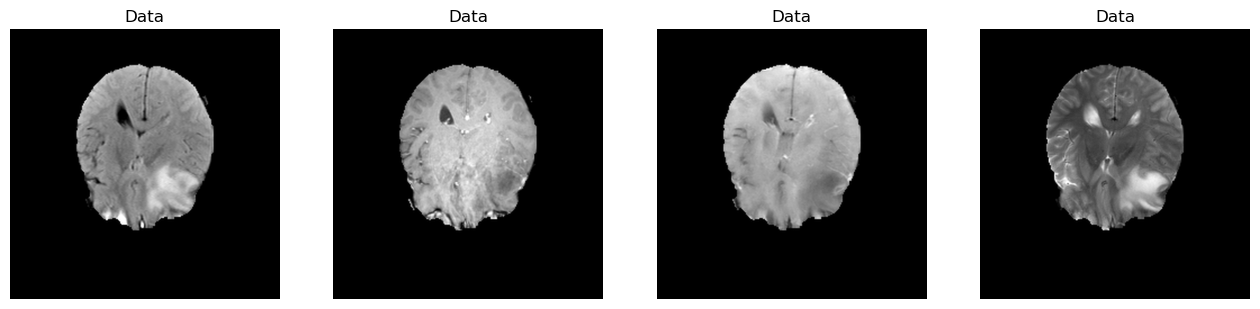

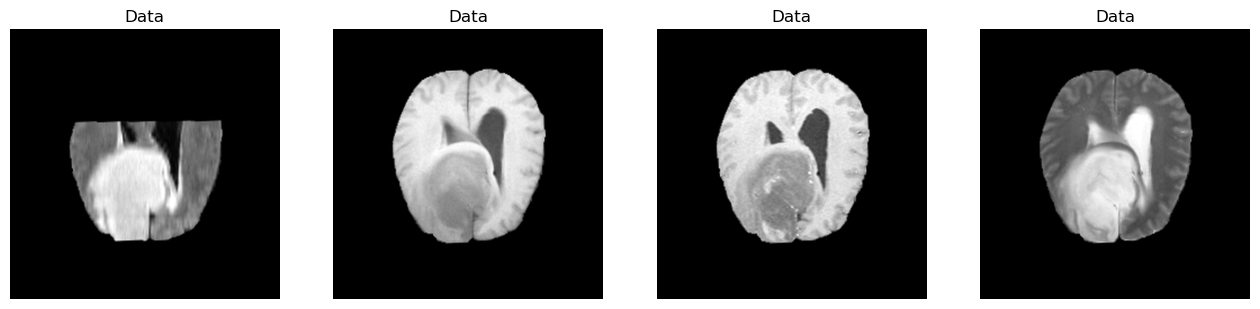

In [14]:
for batch_id in range(image.shape[0]):
    image_show = image.detach().numpy()[batch_id]
    plot_modalities(image_show)
#     _, ax = plt
#     for modality_id in image.shape[1]:
# plt.imshow(image.detach().numpy()[0, 1], cmap='gray')

In [ ]:
image_adv_pgd = pgd_attack(medsam_model, images=image, boxes_np=boxes_np, labels=gt2D, eps=epsilon)

In [4]:
epsilon_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for epsilon in epsilon_list:
    # epsilon /= 10
    print(f'Now the epsilon is {epsilon}')
    for step, (image, gt2D, boxes, names_temp) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        boxes_np = boxes.detach().cpu().numpy()

        image, gt2D = image.to(device), gt2D.to(device)

        image_adv_pgd = pgd_attack(medsam_model, images=image, boxes_np=boxes_np, labels=gt2D, eps=epsilon)
        
        image_adv_fgsm = fgsm_attack(medsam_model, images=image, boxes_np=boxes_np, labels=gt2D, eps=epsilon)
        
        for idx in range(image.shape[0]):
            save_tensor_as_npy(image_adv_pgd[idx], join(all4_file_path, 'pgd', f'eps={epsilon}', names_temp[idx]))
            save_tensor_as_npy(image_adv_fgsm[idx], join(all4_file_path, 'fgsm', f'eps={epsilon}', names_temp[idx]))
        
        break
        del image_adv_pgd
        del image_adv_fgsm

Now the epsilon is 0.1


  0%|                                                                                                                                                                                                                  | 0/1275 [00:00<?, ?it/s]

START IMAGE: torch.Size([2, 4, 1024, 1024]), 1.0, 0.0
START LABEL: torch.Size([2, 1, 1024, 1024])


  0%|                                                                                                                                                                                                                  | 0/1275 [00:01<?, ?it/s]


KeyboardInterrupt: 